# IMPORTING NECESSARY LIBRARIES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical, split_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.optimizers import Adam
import os
import  cv2
import re

# IMPORTING DATA FROM KAGGLE

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chinese-mnist


In [ ]:
df = pd.read_csv(os.path.join(path,'chinese_mnist.csv'))

# DESCRIPTIVE STATISTICS

In [ ]:
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [ ]:
df['character'].unique()

array(['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六',
       '七', '八'], dtype=object)

In [ ]:
os.listdir(os.path.join(path,'data', 'data'))[:5]

['input_3_9_14.jpg',
 'input_29_9_14.jpg',
 'input_86_3_5.jpg',
 'input_67_10_4.jpg',
 'input_35_4_4.jpg']

      suite_id  sample_id  code  value character
4239         3          9    14  10000         万


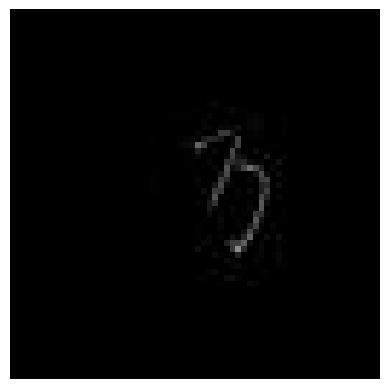

In [ ]:
img_bgr = cv2.imread(os.path.join(os.path.join(path,'data', 'data'), 'input_3_9_14.jpg'))

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
print(df[(df['suite_id']==3) & (df['sample_id']==9) & (df['code']==14)])
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

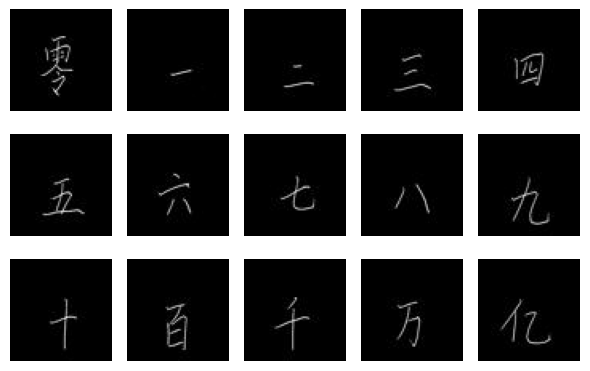

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(6, 4))

ex_img_path = [f'input_1_1_{x}.jpg' for x in range(1, 16)]

for i in range(3):
    for j in range(5):
        img_bgr = cv2.imread(os.path.join(path,'data', 'data', ex_img_path[0]))
        ex_img_path.pop(0)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# MAPPING THE LABES AND THEIR ENCODERS

In [ ]:
classes_index = [x for x in range(1, 16)]
class_ = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '百', '千', '萬', '億']

mapping = dict(zip(classes_index, class_))
mapping

{1: '零',
 2: '一',
 3: '二',
 4: '三',
 5: '四',
 6: '五',
 7: '六',
 8: '七',
 9: '八',
 10: '九',
 11: '十',
 12: '百',
 13: '千',
 14: '萬',
 15: '億'}

# INORDER TO CREATE CUSTOM DATA MAKE LIST OF LABELS AND IMAGES

In [ ]:
labels = [int(re.split('_|\.', fname)[-2]) for fname in os.listdir(os.path.join(path,'data', 'data'))]
labels[:5]

[14, 14, 5, 4, 4]

In [ ]:
images = list()

for i in os.listdir(os.path.join(path,'data', 'data')):
        img_bgr = cv2.imread(os.path.join(path,'data', 'data', i))
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        images.append(img)


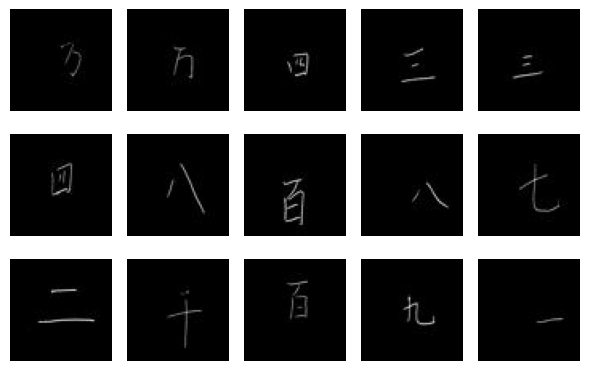

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(6, 4))

k = 0
for i in range(3):
    for j in range(5):
        img = images[k]

        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        k+=1

plt.tight_layout()
plt.show()

# CREATE CUSTOM DATA

In [ ]:
data = tf.data.Dataset.from_tensor_slices((images, labels))

# TRAIN AND TEST SPLIT

In [ ]:
train_ds, test_ds = split_dataset(data, left_size=0.8, right_size=0.2, shuffle=True)

# INORDER TO SEPERATE INPUTS AND OUTPUTS CONVERT DATASETS TO NUMPY FORMAT

In [ ]:
# Select all batches from the dataset one by one and merge them
def dataset_to_numpy(dataset):
    x = []
    y = []
    for x_batch, y_batch in dataset:
        x.append(x_batch.numpy())
        y.append(y_batch.numpy())
    # Convert lists of arrays to unified NumPy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

In [ ]:
x_train.shape

(12000, 64, 64, 3)

In [ ]:
y_train

array([1, 9, 2, ..., 6, 5, 7], dtype=int32)

In [ ]:
num_classes = len(classes_index)+1
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# MODEL BUILDING (LENET-5)

In [ ]:
# Model Architecture LeNet-5
def build_lenet():
    model = models.Sequential([
        layers.Conv2D(6, (5,5), activation='relu', input_shape=(64,64,3), padding='same'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, (5,5), activation='relu'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# TRAIN AND EVALUATION METHOD

In [ ]:
# Train and Evaluation
def train_and_evaluate(model_fn, name):
    model = model_fn()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_split=0.1, verbose=1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    y_pred = model.predict(x_test)

    # Get class labels from one-hot encoded y_test
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    report = classification_report(y_test_classes, y_pred_classes, output_dict=True)

    return {
        "name": name,
        "model": model,
        "history": history,
        "accuracy": test_acc,
        "loss": test_loss,
        "confusion_matrix": cm,
        "report": report
    }

# TRAINING THE MODEL

In [ ]:
results = train_and_evaluate(build_lenet, 'LeNet')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2956 - loss: 2.6125 - val_accuracy: 0.7392 - val_loss: 0.8897
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8151 - loss: 0.6081 - val_accuracy: 0.8942 - val_loss: 0.3633
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9280 - loss: 0.2440 - val_accuracy: 0.9142 - val_loss: 0.2960
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9555 - loss: 0.1425 - val_accuracy: 0.9367 - val_loss: 0.2230
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9766 - loss: 0.0841 - val_accuracy: 0.9408 - val_loss: 0.1956
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


# PERFORMANS MEASUREMENT
## PLOTTING ACCURACY & LOSS CHARTS

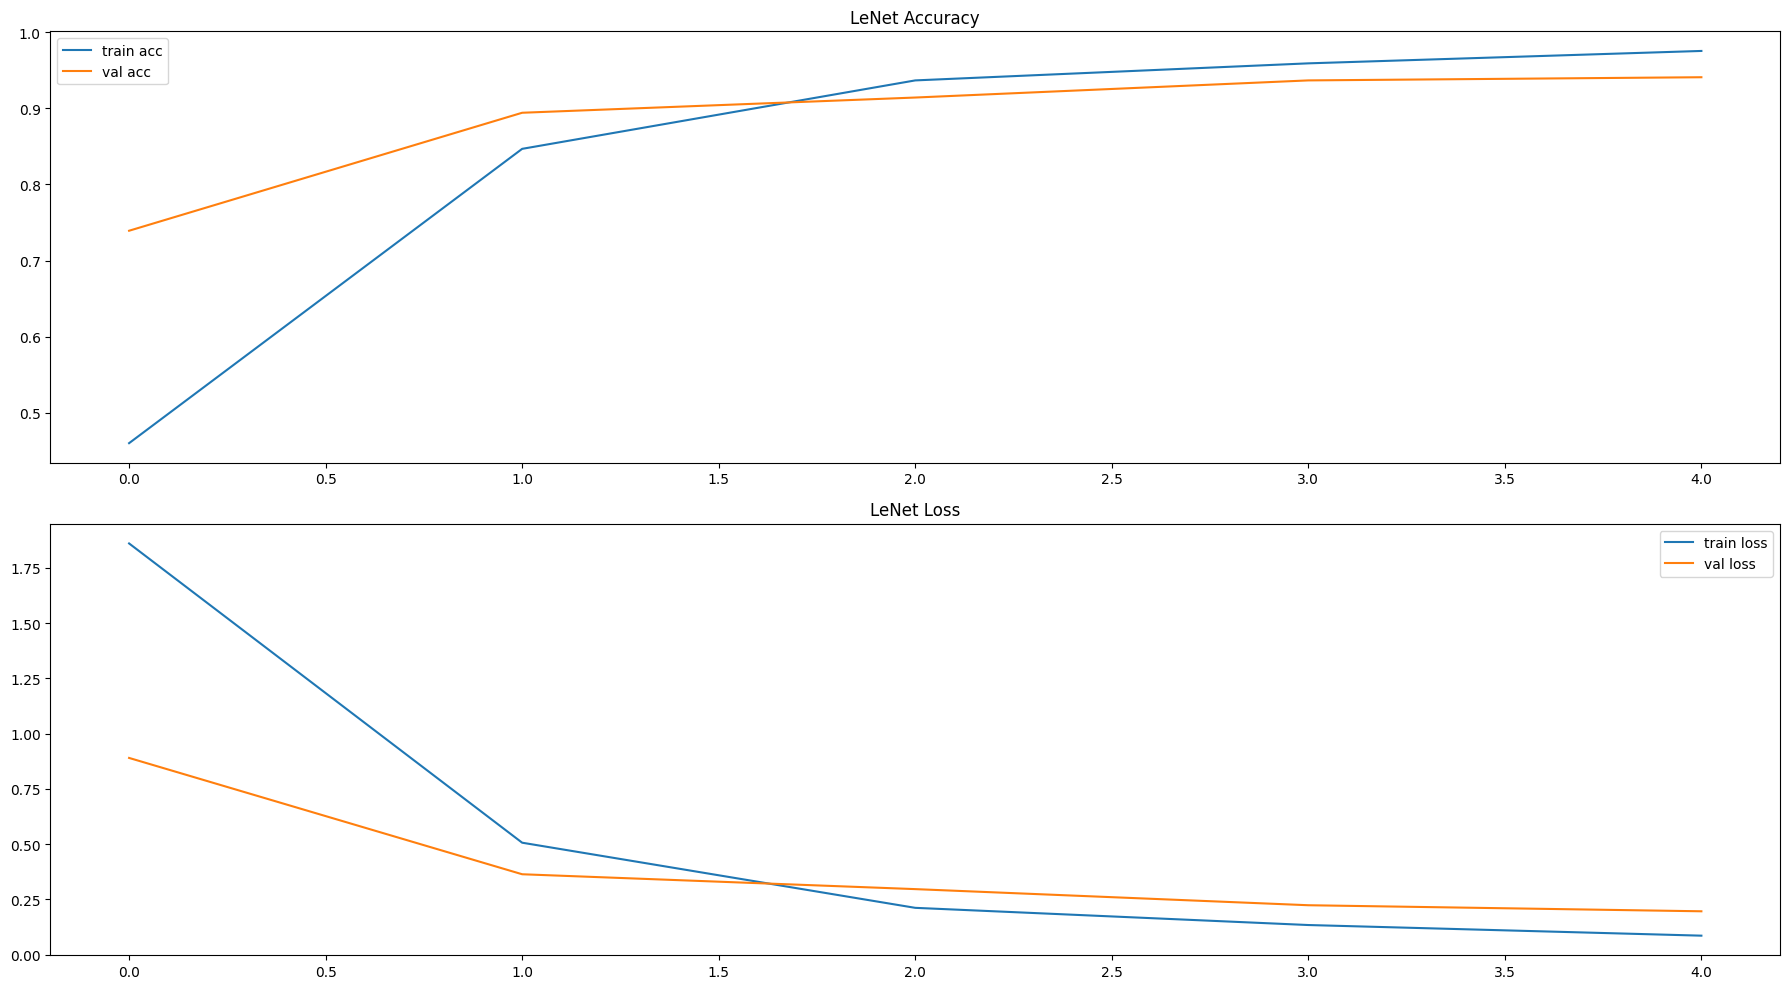

In [ ]:
# Plotting Accuracy & Loss
fig_hist, axes = plt.subplots(2, 1, figsize=(18, 10))
history = results["history"]
axes[0].plot(history.history['accuracy'], label='train acc')
axes[0].plot(history.history['val_accuracy'], label='val acc')
axes[0].set_title(f'{results["name"]} Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='train loss')
axes[1].plot(history.history['val_loss'], label='val loss')
axes[1].set_title(f'{results["name"]} Loss')
axes[1].legend()
plt.tight_layout()
plt.show()

## CONFUSION MATRIX

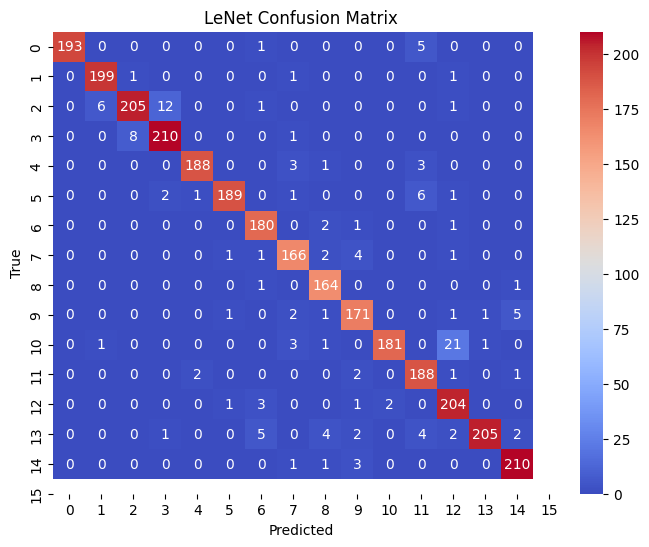

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(results["confusion_matrix"], annot=True, fmt="d", cmap="coolwarm", xticklabels=range(16), yticklabels=range(16))
plt.title(f"{results['name']} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## ALL PERFORMANCE MEASUREMENT METRICS

In [ ]:
report = results["report"]
report_df = pd.DataFrame(report).transpose()
display(report_df)

,precision,recall,f1-score,support
1,1.000000,0.969849,0.984694,199.000
2,0.966019,0.985149,0.975490,202.000
3,0.957944,0.911111,0.933941,225.000
4,0.933333,0.958904,0.945946,219.000
5,0.984293,0.964103,0.974093,195.000
6,0.984375,0.945000,0.964286,200.000
7,0.937500,0.978261,0.957447,184.000
8,0.932584,0.948571,0.940510,175.000
9,0.931818,0.987952,0.959064,166.000
10,0.929348,0.939560,0.934426,182.000
